# Custom Components: News Summarizer

### Preliminaries

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

### Build the News Fetcher Component

- The component should be able to retrieve the most recent or trending stories from _Hacker News_ using their API. This will involve making HTTP requests to the Hacker News API to get the IDs of the top stories and then fetching details for each story.
- _Hacker News_ posts can include links to external websites or contain text directly within the post. The component should be able to handle both types of content:
    - For posts with URLs, it should fetch the linked content.
    - For text-based posts, it should directly process the text.
- For posts with URLs, the component should download the web page content and convert the HTML into a structured document format that can be used in further processing or indexing.

In [21]:
# Just download and output the top story from Hacker News

import requests

trending_list = requests.get(
        url="https://hacker-news.firebaseio.com/v0/topstories.json?print=pretty"
    )
post = requests.get(
    url=f"https://hacker-news.firebaseio.com/v0/item/{trending_list.json()[0]}.json?print=pretty"
)

print(post.json())

{'by': 'jmorgan', 'descendants': 168, 'id': 41375548, 'kids': [41375657, 41375719, 41375667, 41377398, 41378058, 41375811, 41377191, 41376434, 41377336, 41378143, 41378135, 41376371, 41377990, 41375678, 41378131, 41377357, 41376855, 41378020, 41377838, 41377889, 41375765, 41376927, 41377690, 41375704, 41377172, 41377364, 41376036, 41376913, 41377219, 41377322, 41376249, 41376166, 41376001, 41376183, 41377681, 41376977, 41377520, 41377728, 41377240, 41375925, 41375846, 41375701, 41376004, 41377385, 41376518, 41376737, 41376333, 41377524, 41377824, 41375861, 41376132, 41375911, 41376269], 'score': 592, 'time': 1724813980, 'title': 'Diffusion Models Are Real-Time Game Engines', 'type': 'story', 'url': 'https://gamengen.github.io'}


**Component Structure:**

The `__init__` method is s responsible for setting up the core infrastructure of the component: initialize the necessary components and set up the pipeline that will handle the content fetching and conversion process
- Use a component like `LinkContentFetcher` to download the content from URLs found in _Hacker News_ posts.
- Use a component like `HTMLToDocument` to convert the fetched HTML content into a structured `Document` format.
- Set up a pipeline (`html_conversion_pipeline`) that connects the fetcher and converter. This pipeline will take URLs as input, fetch the content, and output structured documents.

The `run` method executes the main logic of fetching the latest stories from _Hacker News_, processing them through the pipeline, and returning the results.
- Make a request to the Hacker News API to retrieve the IDs of the top stories.
Loop through the top stories and:
    - For URL-Based Posts: Use the pipeline to fetch and convert the HTML content into documents.
	- For Text-Based Posts: Directly create `Document` objects from the text content and metadata.
- Return a list of `Document` objects representing the processed articles.

In [42]:
from typing import List

from haystack import component, Pipeline, Document
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument

@component
class HackernewsNewestFetcher:
    def __init__(self):
        fetcher = LinkContentFetcher()
        converter = HTMLToDocument()

        html_conversion_pipeline = Pipeline()
        html_conversion_pipeline.add_component("fetcher", fetcher)
        html_conversion_pipeline.add_component("converter", converter)

        html_conversion_pipeline.connect("fetcher", "converter")
        self.html_pipeline = html_conversion_pipeline

    @component.output_types(articles=List[Document])
    def run(self, top_k: int):
        articles = []
        trending_list = requests.get(
            url="https://hacker-news.firebaseio.com/v0/topstories.json?print=pretty"
        )

        for id in trending_list.json()[0:top_k]:
            post = requests.get(
                url=f"https://hacker-news.firebaseio.com/v0/item/{id}.json?print=pretty"
            )
            if "url" in post.json():
                try: 
                    article = self.html_pipeline.run(
                        {"fetcher": {"urls": [post.json()["url"]]}}
                    )
                    articles.append(article["converter"]["documents"][0])
                except:
                    print(f"Can't download post with id {post.json()["id"]}, skipped, please take a look at {post.json()["url"]}\n")
            elif "text" in post.json():
                try:
                    articles.append(Document(content=post.json()["text"], meta={"title": post.json()["title"]}))
                except:
                    print(f"Can't download post with id {post.json()["id"]}, skipped, please take a look at {post.json()["url"]}\n")

        return {"articles": articles}



In [44]:
fetcher = HackernewsNewestFetcher()
results = fetcher.run(top_k=3)

print(results['articles'])

Can't download post with id 41376820, skipped, please take a look at https://www.researchgate.net/publication/355242503_Final_Two_Communications_from_MH370_Supports_Controlled_Eastward_Descent_Scenario

[Document(id=76a748fb0b7e4bba770e1c391fe857f731e1fd578df8305b48d46b8c6215836d, content: 'We present GameNGen, the first game engine powered entirely by a neural model that enables real-time...', meta: {'content_type': 'text/html', 'url': 'https://gamengen.github.io'}), Document(id=b46611757a760ac7556c902bee19bcf75a730de9036cf900876c6465c8762b85, content: 'Cross platform, open source .NET framework
The Mono Project (mono/mono) (‘original mono’) has been a...', meta: {'content_type': 'text/html', 'url': 'https://www.mono-project.com/'})]


### Utilize the News Fetcher Component in a News Summarizer Pipeline

In [45]:
'''
prompt_template = """  
You will be provided a few of the top posts in HackerNews.  
For each post, provide a brief summary if possible.
  
Posts:  
{% for article in articles %}
  Post:\n
  {{ article.content}}
{% endfor %}  
"""
'''

prompt_template = """  
You will be provided a few of the top posts in HackerNews, followed by their URL.  
For each post, provide a brief summary followed by the URL the full post can be found at.  
  
Posts:  
{% for article in articles %}  
  {{ article.content }}
  URL: {{ article.meta["url"] }}
{% endfor %}  
"""

In [46]:
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator

prompt_builder = PromptBuilder(template=prompt_template)
fetcher = HackernewsNewestFetcher()
llm = OpenAIGenerator()

summarizer_pipeline = Pipeline()
summarizer_pipeline.add_component("fetcher", fetcher)
summarizer_pipeline.add_component("prompt", prompt_builder)
summarizer_pipeline.add_component("llm", llm)

summarizer_pipeline.connect("fetcher.articles", "prompt.articles")
summarizer_pipeline.connect("prompt", "llm")

🚅 Components
  - fetcher: HackernewsNewestFetcher
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - fetcher.articles -> prompt.articles (List[Document])
  - prompt.prompt -> llm.prompt (str)

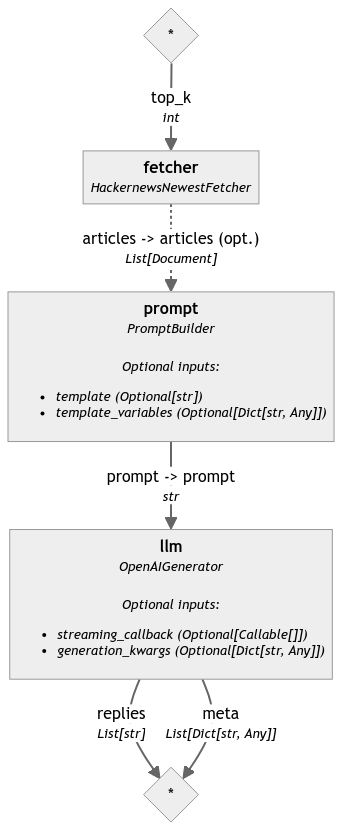

In [47]:
summarizer_pipeline.show()

In [51]:
summaries = summarizer_pipeline.run({"fetcher": {"top_k": 2}})

print(summaries["llm"]["replies"][0])

Summary: GameNGen is a game engine powered by a neural model that allows real-time interaction with complex environments like the classic game DOOM. It can simulate the game at over 20 frames per second on a single TPU, achieving high quality next frame prediction comparable to lossy JPEG compression. The engine is trained in two phases, with an RL-agent learning to play the game and a diffusion model producing the next frame based on past frames and actions. More information can be found at https://gamengen.github.io

Summary: The Mono Project, a cross-platform, open-source .NET framework, is transitioning stewardship to the WineHQ organization. Microsoft, which acquired Xamarin in 2016, has maintained a modern fork of the Mono runtime in the dotnet/runtime repo. Active Mono users are encouraged to migrate to .NET, as Microsoft has completed moving workloads to that fork. The Mono Project played a significant role in enabling .NET on various operating systems and platforms. More infor